In [93]:
# export

import pandas as pd
import numpy as np
from pathlib import Path
import os, shutil
from subprocess import *

In [240]:
from pprint import pprint

In [181]:
# export

#Logging configuration

import logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='mylog.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.INFO)

## error_checker

> This module provides a tool for analyzing java source code and get compilation error report. Provides a python interface for a custom jar

> @Alvaro 05 April 2021

This methods lets us execute external jar files from python.

### Errors definition

Java errors definition in order to get generic enough error descriptions

As there isn't any oficial documentation, this is based on some posts:

- [Compile-time errors](!https://student.cs.uwaterloo.ca/~cs133/Resources/Java/Debugging/compile.shtml)
- [Compile and Runtime Errors in Java](!https://introcs.cs.princeton.edu/java/11cheatsheet/errors.pdf)
- [Compile time error messages - Glossary](!https://www.mindprod.com/jgloss/compileerrormessages.html#UNEXPECTEDSYMBOLS)

In [259]:
#export

# Most generic errors --> the ones to be replaced first without loosing most specific errors

fixed_errors = {
    "cannot_find_symbol": "cannot find symbol",
    "non_existing_package": "package [a-zA-Z0-9_\.]+ does not exist",
}


# Errors to be found based on regex
regex_errors = {
    "not_visible_package": "package [a-zA-Z0-9_\.]+ is not visible",
    "exception": "^[A-Za-z]+Exception$",
    "special_char_expected": "'?(\(|\)|;|\[|\]|\<|\>)'? expected",
    "non_applicable_method_diff_len": "method .* cannot be applied .* reason: actual and formal argument lists differ in length",
    "non_apllicable_method_varargs_mismatch": "method .* cannot be applied .* reason: varargs mismatch",
    "ambiguous_reference": "reference to [A-Za-z]+ is ambiguous",
    "no_suitable_method_diff_length": "no suitable method found for .* actual and formal argument lists differ in length",
    "no_suitable_method_varargs_mismatch": "no suitable method found for .* varargs mismatch",
    "non_static_var_from_static_context": "non-static variable .* cannot be referenced from a static context",
    "cannot_be_dereferenced": "<?[A-Za-z]+>? cannot be dereferenced",
    "method_cannot_be_applied_to_given_types": "method .* in class .* cannot be applied to given types",
    "no_suitable_constructor": "^no suitable constructor found for",
    "unexpected_type": "unexpected type(\s)*required:(\s)*([a-zA-Z0-9_]+)(\s)*found:",
}

In [260]:
# export

# Errors to be found based on specific names
# Note just a part of the error description is included but it is searched based on str coincidence

named_errors = {
    "method_doesnot_override_implement_super": "method does not override or implement a method",
    "unexpected_lambda": "lambda expression not expected",
    "expected_structure": "class, interface, or enum expected",
    "illegal_parenthesized_expression": "illegal parenthesized expression",
    "incompatible_types": "incompatible types",
    "for_each_not_applicable": "for-each not applicable to expression type",
    "return_required": "return required",
    "deprecated_usage": "has been deprecated and marked for removal",
    "incomparable_types": "incomparable types"
}


# Warning (errors) to be found based on names (str coincidence)

warnings = {
    "warn_deprecated_API": "uses or overrides a deprecated API",
    "warn_unsafe_operations": "uses unchecked or unsafe operations",
    "xdiags_warning": "recompile with -Xdiags:verbose to get full output",
    "xlint_warning": "Recompile with -Xlint",
    "non_varargs-warning": "non-varargs call of varargs method with inexact argument type for last parameter"
}

In [247]:
fake_dict = {
    "error": [
        "package com.sun.tools.javac.code is not visible   (package com.sun.tools.javac.code is declared in module jdk.compiler, which does not export it to the unnamed module)",
        ""
    ]
}

In [249]:
fake_df = pd.DataFrame(fake_dict)

In [250]:
fake_df.loc[fake_df['error'].str.contains("package [a-zA-Z0-9_\.]+ is not visible", regex=True)]
# df_copy.loc[df_copy[error_column].str.contains(v, case=False, regex=True), error_column]

,error
0,package com.sun.tools.javac.code is not visibl...


In [131]:
# export

name_coincidence_errors = {
    **named_errors,
    **warnings
}

### Utils

All the error analysis is performed by an external tool originally written in Java, that's why we specify a utility method for executing jar programs from python

In [9]:
# export

def jarWrapper(*args):
    """
    Function for executing jar files from python
    :param args: Arguments to be passed for the executed program
    :returns: Output produced by the executed jar
    """
    process = Popen(['java', '-jar']+list(args), stdout=PIPE, stderr=PIPE)
    ret = []
    while process.poll() is None:
        line = process.stdout.readline()
        if line != '' and line.endswith(b'\n'):
            ret.append(line[:-1])
    stdout, stderr = process.communicate()
    
    ret += stdout.split(b'\n')
    if stderr != '':
        ret += stderr.split(b'\n')
        
    if '' in ret:
        ret.remove('')
    return ret

In [17]:
def process_chars_for_bpes(code_snippet):
    return code_snippet.replace('\n', '<n>').replace('\t', '<t>').replace('@', '<@>')

## Error checker

In [125]:
# export

class JavaErrorChecker():
    def __init__(self, jar_path):
        self.jar_path = jar_path

    def perform_analysis(self, code_df, idx_column, error_column):
        """
        Performs the error analysis and gets the report error report
        :param  code_df: Pandas Dataframe with the required structure containing the code to be analyzed
        :param idx_column: Column name to reference the snippets in the generated report
        :param error_column: Column name to reference the error details in the generated report
        """
        
        self.__create_aux_dirs()
        out_csv_name = "error_analysis_report.csv"
        code_csv_name = "code.csv"
        code_df.to_csv(str(self.resources_path/code_csv_name), index=False)
        args = [self.jar_path, code_csv_name, out_csv_name]
        
        try:
            jar_result = jarWrapper(*args)
            logging.info(f'jar program produced this output: {jar_result}')
        except Exception as e:
            logging.error(f'An error ocurred when trying to execute the jar program')
            #print(e.message, e.args)    
            
        processed_df =  self.__process_results(out_csv_name, idx_column, error_column)
        self.__remove_aux_files()
        
        return processed_df
        
            
    def __process_results(self, out_name, idx_column, error_column):
        errors_report_df = pd.read_csv(str(self.resources_path/out_name), delimiter = '\t')
        clean_df = self.__get_generic_errors(errors_report_df, fixed_errors, regex_errors, name_coincidence_errors, error_column)
        dimension_based_df = self.__get_error_dims_records(clean_df, idx_column, error_column)
        return dimension_based_df
        
    def __get_generic_errors(self, df, fixed_errors, regex_errors, named_errors, error_column):
        """
        Performs processing for error names
        :param df: Pandas dataframe containing errors info.
        :param fixed_errors: Dictionary containing the names-regex for more generic error names
        :param regex_errors: Dictionary containing regex defining generic error names
        :param named_errors: Dictionary containing generic error names
        :param error_column: Column name to access to access errors in df
        :returns: Processed dataframe
        """
        logging.info('Processing external report.')
        df_copy = df.copy()
    
        # Replace most generic errors first
        for k, v in fixed_errors.items():
            df_copy.loc[df_copy[error_column].str.contains(v, case=False, regex=True), error_column] = k

        for k, v in regex_errors.items():
            df_copy.loc[df_copy[error_column].str.contains(v, case=False, regex=True), error_column] = k

        for k, v in named_errors.items():
            df_copy.loc[df_copy[error_column].str.contains(v, case=False, regex=False), error_column] = k

        return df_copy
    
    
    def __get_error_dims_records(self, df, idx_column, error_column):
        logging.info('Getting error dimensions.')
        # Group/count errors for each class
        grouped_errors = df.groupby([idx_column, error_column])[error_column].count().reset_index(name='count')
        
        # Turn errors rows into columns (dimensions for vectors)
        pivot_df = grouped_errors.pivot(index=idx_column, columns=error_column, values='count').reset_index()
        pivot_df = pivot_df.fillna(0)
        
        return pivot_df
    
    def __remove_aux_files(self):
        """
        Removes auxiliar - tmp directories/files created for the functioning of the external package
        """
        logging.info('Removing auxiliar directories/files.')
        shutil.rmtree(str(self.base_path))
        
    def __create_aux_dirs(self):
        logging.info('Creating auxiliar directories.')
        self.out_path = Path(".")
        # Configure directories for jar tool
        self.base_path = self.out_path / "java"
        self.resources_path = self.base_path / "resources"
        self.compiled_path = self.resources_path / "compiled"
        self.base_path.mkdir(exist_ok=True)
        self.resources_path.mkdir(exist_ok=True)
        self.compiled_path.mkdir(exist_ok=True)

### Usage

In [18]:
java_df = pd.read_csv('/tf/main/dvc-ds4se/code/searchnet/clean_java.csv')

In [422]:
java_df.head()

,Unnamed: 0,code,code_len,code_tokens,cyclomatic_complexity,data_type,method_name,nloc,parameter_count,partition,token_count
0,0,protected final void fastPathOrderedEmit(U val...,134.0,"['protected', 'final', 'void', 'fastPathOrdere...",7.0,src,fastPathOrderedEmit,20.0,3.0,test,131.0
1,1,@CheckReturnValue\n @NonNull\n @Schedule...,63.0,"['@', 'CheckReturnValue', '@', 'NonNull', '@',...",1.0,src,amb,4.0,1.0,test,43.0
2,2,"@SuppressWarnings(""unchecked"")\n @CheckRetu...",107.0,"['@', 'SuppressWarnings', '(', '""unchecked""', ...",3.0,src,ambArray,11.0,1.0,test,82.0
3,3,"@SuppressWarnings({ ""unchecked"", ""rawtypes"" })...",79.0,"['@', 'SuppressWarnings', '(', '{', '""unchecke...",1.0,src,concat,4.0,1.0,test,50.0
4,4,"@SuppressWarnings({ ""unchecked"", ""rawtypes"" })...",91.0,"['@', 'SuppressWarnings', '(', '{', '""unchecke...",1.0,src,concat,5.0,2.0,test,62.0


In [423]:
java_samples = java_df.sample(100)

In [424]:
java_samples['code'] = java_samples['code'].apply(lambda method: process_chars_for_bpes(method))

In [425]:
idx_column = [i for i in range(java_samples.shape[0])]

In [426]:
stop_column = ['*stop*' for _ in range(java_samples.shape[0])]

In [427]:
java_samples['idx'] = idx_column
java_samples['stop_column'] = stop_column

In [428]:
java_samples = java_samples[['idx', 'code', 'stop_column']]

In [429]:
java_samples.head()

,idx,code,stop_column
356621,0,public WsByteBuffer[] buildFrameArrayForWrite(...,*stop*
110141,1,protected Result buildResult(String resultCode...,*stop*
64588,2,public void initialState() {<n><n> comm...,*stop*
202174,3,"public static String get(final String key, fin...",*stop*
156069,4,public TrajectoryEnvelope[] getTrajectoryEnvel...,*stop*


In [431]:
java_samples.to_csv('java/resources/java_samples.csv', index=False)

In [432]:
jar_path = '/tf/main/tools/soft-sintax-checker.jar'

In [433]:
java_error_checker = JavaErrorChecker(jar_path)

In [434]:
error_report_df = java_error_checker.perform_analysis(java_samples, 'ID Class', ' error message')

2021-04-14 15:06:06,639 : INFO : Creating auxiliar directories.
2021-04-14 15:06:09,092 : INFO : jar program produced this output: [b'', b'']
2021-04-14 15:06:09,103 : INFO : Processing external report.
/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
2021-04-14 15:06:09,166 : INFO : Getting error dimensions.
2021-04-14 15:06:09,175 : INFO : Removing auxiliar directories/files.


In [435]:
error_report_df

error message,ID Class,cannot_find_symbol,illegal_parenthesized_expression,method_doesnot_override_implement_super,non_existing_package
0,0,21.0,3.0,0.0,0.0
1,1,7.0,0.0,0.0,1.0
2,2,4.0,0.0,0.0,0.0
3,3,2.0,0.0,0.0,0.0
4,4,10.0,0.0,0.0,0.0
...,...,...,...,...,...
95,95,7.0,0.0,0.0,0.0
96,96,2.0,0.0,0.0,1.0
97,97,5.0,0.0,0.0,0.0
98,98,6.0,0.0,0.0,1.0


In [436]:
error_report_df.describe()

error message,ID Class,cannot_find_symbol,illegal_parenthesized_expression,method_doesnot_override_implement_super,non_existing_package
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,49.500000,9.050000,0.050000,0.120000,0.250000
std,29.011492,9.616248,0.329524,0.326599,0.757121
min,0.000000,1.000000,0.000000,0.000000,0.000000
25%,24.750000,3.750000,0.000000,0.000000,0.000000
50%,49.500000,6.000000,0.000000,0.000000,0.000000
75%,74.250000,10.250000,0.000000,0.000000,0.000000
max,99.000000,61.000000,3.000000,1.000000,6.000000


In [437]:
columns = [column for column in error_report_df.columns if column != 'ID Class']

In [438]:
error_report_df.columns

Index(['ID Class', 'cannot_find_symbol', 'illegal_parenthesized_expression',
       'method_doesnot_override_implement_super', 'non_existing_package'],
      dtype='object', name=' error message')

In [439]:
columns

['cannot_find_symbol',
 'illegal_parenthesized_expression',
 'method_doesnot_override_implement_super',
 'non_existing_package']

In [440]:
error_report_df[columns].describe()['cannot_find_symbol']['mean']

9.05

## Errors selection

Run the error analysis several times in order to get some statistics about the ocurrence of errors.

In [160]:
from collections import defaultdict

In [441]:
from tqdm import tqdm

In [442]:
def get_code_df_samples(code_df, n_samples):
    """"""
    samples = code_df.sample(n_samples)
    # Preprocess for special chars.
    samples['code'] = samples['code'].apply(lambda method: process_chars_for_bpes(method))
    # Include auxiliar columns for external tool
    idx_column = [i for i in range(samples.shape[0])]
    stop_column = ['*stop*' for _ in range(samples.shape[0])]
    samples['idx'] = idx_column
    samples['stop_column'] = stop_column
    samples = samples[['idx', 'code', 'stop_column']]
    
    return samples


def run_multiple_error_experiments(code_df, error_check_jar_path, n_samples, n_runs):
    
    error_checker = JavaErrorChecker(error_check_jar_path)
    
    errors_count = {}
    for r in tqdm(range(n_runs)):
        samples_df = get_code_df_samples(code_df, n_samples)
        results_df = error_checker.perform_analysis(samples_df, 'ID Class', ' error message')
        error_columns = [column for column in results_df.columns if column != 'ID Class']
        # TODO: Check stats for corresponding errors
        description = results_df[error_columns].describe()
        iter_stats_name = f'stats_iter_{r}'
        
        for error in error_columns:
            mean = description[error]['mean']
            std = description[error]['std']
            max_ = description[error]['max']
            
            if error in errors_count:
                errors_count[error]['count'] += 1
            else:
                errors_count[error] = {
                    'count': 1,
                    'mean': [0] * n_runs,
                    'std': [0] * n_runs,
                    'max': [0] * n_runs
                }
            
            errors_count[error]['mean'][r] = mean
            errors_count[error]['std'][r] = std
            errors_count[error]['max'][r] = max_
                
    return errors_count

In [443]:
java_df.head()

,Unnamed: 0,code,code_len,code_tokens,cyclomatic_complexity,data_type,method_name,nloc,parameter_count,partition,token_count
0,0,protected final void fastPathOrderedEmit(U val...,134.0,"['protected', 'final', 'void', 'fastPathOrdere...",7.0,src,fastPathOrderedEmit,20.0,3.0,test,131.0
1,1,@CheckReturnValue\n @NonNull\n @Schedule...,63.0,"['@', 'CheckReturnValue', '@', 'NonNull', '@',...",1.0,src,amb,4.0,1.0,test,43.0
2,2,"@SuppressWarnings(""unchecked"")\n @CheckRetu...",107.0,"['@', 'SuppressWarnings', '(', '""unchecked""', ...",3.0,src,ambArray,11.0,1.0,test,82.0
3,3,"@SuppressWarnings({ ""unchecked"", ""rawtypes"" })...",79.0,"['@', 'SuppressWarnings', '(', '{', '""unchecke...",1.0,src,concat,4.0,1.0,test,50.0
4,4,"@SuppressWarnings({ ""unchecked"", ""rawtypes"" })...",91.0,"['@', 'SuppressWarnings', '(', '{', '""unchecke...",1.0,src,concat,5.0,2.0,test,62.0


In [444]:
errors_count = run_multiple_error_experiments(java_df, jar_path, n_samples=1000, n_runs=200)

  0%|          | 0/200 [00:00<?, ?it/s]2021-04-14 15:07:39,036 : INFO : Creating auxiliar directories.
2021-04-14 15:07:49,976 : INFO : jar program produced this output: [b'', b'']
2021-04-14 15:07:50,000 : INFO : Processing external report.
/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
2021-04-14 15:07:50,190 : INFO : Getting error dimensions.
2021-04-14 15:07:50,201 : INFO : Removing auxiliar directories/files.
  0%|          | 1/200 [00:11<37:21, 11.26s/it]2021-04-14 15:07:50,293 : INFO : Creating auxiliar directories.
2021-04-14 15:08:01,170 : INFO : jar program produced this output: [b'', b'']
2021-04-14 15:08:01,193 : INFO : Processing external report.
/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, *

2021-04-14 15:10:27,873 : INFO : Processing external report.
/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
2021-04-14 15:10:28,061 : INFO : Getting error dimensions.
2021-04-14 15:10:28,071 : INFO : Removing auxiliar directories/files.
  8%|▊         | 15/200 [02:49<34:38, 11.23s/it]2021-04-14 15:10:28,151 : INFO : Creating auxiliar directories.
2021-04-14 15:10:39,150 : INFO : jar program produced this output: [b'', b'']
2021-04-14 15:10:39,175 : INFO : Processing external report.
/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
2021-04-14 15:10:39,371 : INFO : Getting error dimensions.
2021-04-14 15:10:39,382 : INFO : Removing auxiliar directories/files.
  8%|▊         | 16/200 [03:00<34:31, 11.2

2021-04-14 15:13:06,330 : INFO : Getting error dimensions.
2021-04-14 15:13:06,341 : INFO : Removing auxiliar directories/files.
 14%|█▍        | 29/200 [05:27<32:10, 11.29s/it]2021-04-14 15:13:06,435 : INFO : Creating auxiliar directories.
2021-04-14 15:13:17,451 : INFO : jar program produced this output: [b'', b'']
2021-04-14 15:13:17,473 : INFO : Processing external report.
/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
2021-04-14 15:13:17,677 : INFO : Getting error dimensions.
2021-04-14 15:13:17,689 : INFO : Removing auxiliar directories/files.
 15%|█▌        | 30/200 [05:38<32:01, 11.30s/it]2021-04-14 15:13:17,773 : INFO : Creating auxiliar directories.
2021-04-14 15:13:28,640 : INFO : jar program produced this output: [b'', b'']
2021-04-14 15:13:28,661 : INFO : Processing external report.
/usr/local/lib/python3.6/dist-packages/pandas/

 22%|██▏       | 43/200 [08:05<29:34, 11.30s/it]2021-04-14 15:15:44,629 : INFO : Creating auxiliar directories.
2021-04-14 15:15:55,722 : INFO : jar program produced this output: [b'', b'']
2021-04-14 15:15:55,745 : INFO : Processing external report.
/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
2021-04-14 15:15:55,939 : INFO : Getting error dimensions.
2021-04-14 15:15:55,950 : INFO : Removing auxiliar directories/files.
 22%|██▏       | 44/200 [08:17<29:28, 11.33s/it]2021-04-14 15:15:56,045 : INFO : Creating auxiliar directories.
2021-04-14 15:16:07,075 : INFO : jar program produced this output: [b'', b'']
2021-04-14 15:16:07,097 : INFO : Processing external report.
/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self

2021-04-14 15:18:33,185 : INFO : Processing external report.
/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
2021-04-14 15:18:33,366 : INFO : Getting error dimensions.
2021-04-14 15:18:33,377 : INFO : Removing auxiliar directories/files.
 29%|██▉       | 58/200 [10:54<26:28, 11.19s/it]2021-04-14 15:18:33,455 : INFO : Creating auxiliar directories.
2021-04-14 15:18:44,437 : INFO : jar program produced this output: [b'', b'']
2021-04-14 15:18:44,459 : INFO : Processing external report.
/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
2021-04-14 15:18:44,639 : INFO : Getting error dimensions.
2021-04-14 15:18:44,650 : INFO : Removing auxiliar directories/files.
 30%|██▉       | 59/200 [11:05<26:21, 11.2

2021-04-14 15:21:11,643 : INFO : Getting error dimensions.
2021-04-14 15:21:11,654 : INFO : Removing auxiliar directories/files.
 36%|███▌      | 72/200 [13:32<23:55, 11.22s/it]2021-04-14 15:21:11,731 : INFO : Creating auxiliar directories.
2021-04-14 15:21:22,628 : INFO : jar program produced this output: [b'', b'']
2021-04-14 15:21:22,650 : INFO : Processing external report.
/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
2021-04-14 15:21:22,840 : INFO : Getting error dimensions.
2021-04-14 15:21:22,851 : INFO : Removing auxiliar directories/files.
 36%|███▋      | 73/200 [13:43<23:44, 11.21s/it]2021-04-14 15:21:22,940 : INFO : Creating auxiliar directories.
2021-04-14 15:21:33,913 : INFO : jar program produced this output: [b'', b'']
2021-04-14 15:21:33,936 : INFO : Processing external report.
/usr/local/lib/python3.6/dist-packages/pandas/

 43%|████▎     | 86/200 [16:10<21:26, 11.28s/it]2021-04-14 15:23:49,209 : INFO : Creating auxiliar directories.
2021-04-14 15:24:00,039 : INFO : jar program produced this output: [b'', b'']
2021-04-14 15:24:00,060 : INFO : Processing external report.
/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
2021-04-14 15:24:00,249 : INFO : Getting error dimensions.
2021-04-14 15:24:00,260 : INFO : Removing auxiliar directories/files.
 44%|████▎     | 87/200 [16:21<21:09, 11.23s/it]2021-04-14 15:24:00,332 : INFO : Creating auxiliar directories.
2021-04-14 15:24:11,201 : INFO : jar program produced this output: [b'', b'']
2021-04-14 15:24:11,224 : INFO : Processing external report.
/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self

2021-04-14 15:26:39,377 : INFO : Processing external report.
/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
2021-04-14 15:26:39,574 : INFO : Getting error dimensions.
2021-04-14 15:26:39,586 : INFO : Removing auxiliar directories/files.
 50%|█████     | 101/200 [19:00<19:15, 11.67s/it]2021-04-14 15:26:39,678 : INFO : Creating auxiliar directories.
2021-04-14 15:26:50,723 : INFO : jar program produced this output: [b'', b'']
2021-04-14 15:26:50,743 : INFO : Processing external report.
/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
2021-04-14 15:26:50,923 : INFO : Getting error dimensions.
2021-04-14 15:26:50,934 : INFO : Removing auxiliar directories/files.
 51%|█████     | 102/200 [19:11<18:53, 11

2021-04-14 15:29:17,669 : INFO : Getting error dimensions.
2021-04-14 15:29:17,686 : INFO : Removing auxiliar directories/files.
 57%|█████▊    | 115/200 [21:38<16:02, 11.33s/it]2021-04-14 15:29:17,780 : INFO : Creating auxiliar directories.
2021-04-14 15:29:28,837 : INFO : jar program produced this output: [b'', b'']
2021-04-14 15:29:28,856 : INFO : Processing external report.
/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
2021-04-14 15:29:29,041 : INFO : Getting error dimensions.
2021-04-14 15:29:29,052 : INFO : Removing auxiliar directories/files.
 58%|█████▊    | 116/200 [21:50<15:52, 11.34s/it]2021-04-14 15:29:29,144 : INFO : Creating auxiliar directories.
2021-04-14 15:29:40,167 : INFO : jar program produced this output: [b'', b'']
2021-04-14 15:29:40,193 : INFO : Processing external report.
/usr/local/lib/python3.6/dist-packages/panda

 64%|██████▍   | 129/200 [24:16<13:16, 11.22s/it]2021-04-14 15:31:55,725 : INFO : Creating auxiliar directories.
2021-04-14 15:32:06,577 : INFO : jar program produced this output: [b'', b'']
2021-04-14 15:32:06,595 : INFO : Processing external report.
/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
2021-04-14 15:32:06,776 : INFO : Getting error dimensions.
2021-04-14 15:32:06,787 : INFO : Removing auxiliar directories/files.
 65%|██████▌   | 130/200 [24:27<13:03, 11.19s/it]2021-04-14 15:32:06,864 : INFO : Creating auxiliar directories.
2021-04-14 15:32:18,144 : INFO : jar program produced this output: [b'', b'']
2021-04-14 15:32:18,168 : INFO : Processing external report.
/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(se

2021-04-14 15:34:43,863 : INFO : Processing external report.
/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
2021-04-14 15:34:44,054 : INFO : Getting error dimensions.
2021-04-14 15:34:44,065 : INFO : Removing auxiliar directories/files.
 72%|███████▏  | 144/200 [27:05<10:27, 11.21s/it]2021-04-14 15:34:44,148 : INFO : Creating auxiliar directories.
2021-04-14 15:34:55,062 : INFO : jar program produced this output: [b'', b'']
2021-04-14 15:34:55,084 : INFO : Processing external report.
/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
2021-04-14 15:34:55,262 : INFO : Getting error dimensions.
2021-04-14 15:34:55,281 : INFO : Removing auxiliar directories/files.
 72%|███████▎  | 145/200 [27:16<10:16, 11

2021-04-14 15:37:22,780 : INFO : Getting error dimensions.
2021-04-14 15:37:22,792 : INFO : Removing auxiliar directories/files.
 79%|███████▉  | 158/200 [29:43<07:53, 11.28s/it]2021-04-14 15:37:22,890 : INFO : Creating auxiliar directories.
2021-04-14 15:37:34,066 : INFO : jar program produced this output: [b'', b'']
2021-04-14 15:37:34,089 : INFO : Processing external report.
/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
2021-04-14 15:37:34,274 : INFO : Getting error dimensions.
2021-04-14 15:37:34,286 : INFO : Removing auxiliar directories/files.
 80%|███████▉  | 159/200 [29:55<07:44, 11.34s/it]2021-04-14 15:37:34,369 : INFO : Creating auxiliar directories.
2021-04-14 15:37:45,352 : INFO : jar program produced this output: [b'', b'']
2021-04-14 15:37:45,374 : INFO : Processing external report.
/usr/local/lib/python3.6/dist-packages/panda

 86%|████████▌ | 172/200 [32:21<05:13, 11.19s/it]2021-04-14 15:40:00,064 : INFO : Creating auxiliar directories.
2021-04-14 15:40:11,100 : INFO : jar program produced this output: [b'', b'']
2021-04-14 15:40:11,116 : INFO : Processing external report.
/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
2021-04-14 15:40:11,298 : INFO : Getting error dimensions.
2021-04-14 15:40:11,308 : INFO : Removing auxiliar directories/files.
 86%|████████▋ | 173/200 [32:32<05:03, 11.22s/it]2021-04-14 15:40:11,378 : INFO : Creating auxiliar directories.
2021-04-14 15:40:22,409 : INFO : jar program produced this output: [b'', b'']
2021-04-14 15:40:22,432 : INFO : Processing external report.
/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(se

2021-04-14 15:42:48,493 : INFO : Processing external report.
/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
2021-04-14 15:42:48,687 : INFO : Getting error dimensions.
2021-04-14 15:42:48,699 : INFO : Removing auxiliar directories/files.
 94%|█████████▎| 187/200 [35:09<02:25, 11.17s/it]2021-04-14 15:42:48,785 : INFO : Creating auxiliar directories.
2021-04-14 15:42:59,556 : INFO : jar program produced this output: [b'', b'']
2021-04-14 15:42:59,578 : INFO : Processing external report.
/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
2021-04-14 15:42:59,754 : INFO : Getting error dimensions.
2021-04-14 15:42:59,765 : INFO : Removing auxiliar directories/files.
 94%|█████████▍| 188/200 [35:20<02:13, 11

In [447]:
print(f'Number of unique errors: {len(errors_count)}')
pprint(errors_count.keys())

Number of unique errors: 75
dict_keys(['cannot_be_dereferenced', 'cannot_find_symbol', 'deprecated_API', 'illegal_parenthesized_expression', 'incompatible_types', 'method_cannot_be_applied_to_given_types', 'method_doesnot_override_implement_super', 'non_applicable_method_diff_len', 'non_existing_package', 'unexpected_lambda', 'xdiags_warning', 'xlint_warning', 'expected_structure', 'non_static_var_from_static_context', 'unsafe_operations', 'java.lang.Compiler in java.lang has been deprecated and marked for removal', 'not_visible_package', 'for_each_not_applicable', 'ambiguous_reference', 'type java.lang.Package does not take parameters', 'non-static method getClass() cannot be referenced from a static context', 'non_apllicable_method_varargs_mismatch', 'no_suitable_constructor', 'unexpected_type', 'cannot inherit from final java.lang.Module', 'com.sun.javadoc.Type in com.sun.javadoc has been deprecated and marked for removal', 'java.security.Identity in java.security has been deprecate

In [183]:
import matplotlib.pyplot as plt

([<matplotlib.axis.XTick at 0x7fa116784438>,
 <a list of 75 Text xticklabel objects>)

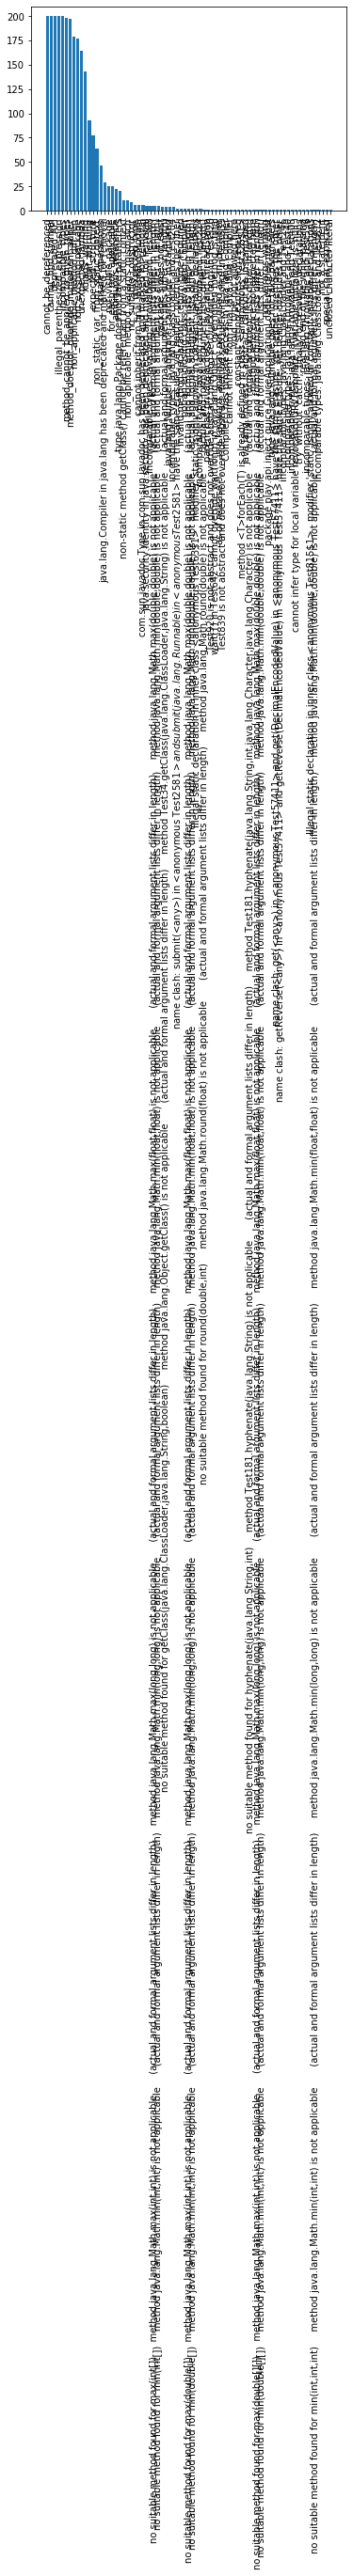

In [448]:
# Errors count

found_errors = errors_count.keys()
found_errors_count = [v['count'] for k,v in errors_count.items()]
found_errors_count.sort(reverse=True)

plt.bar(found_errors, found_errors_count)
plt.xticks(range(len(found_errors)), found_errors, rotation=90)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


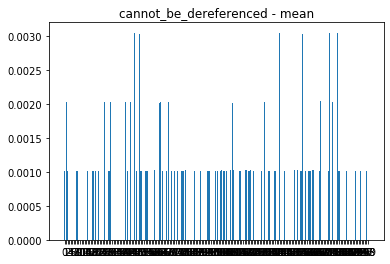

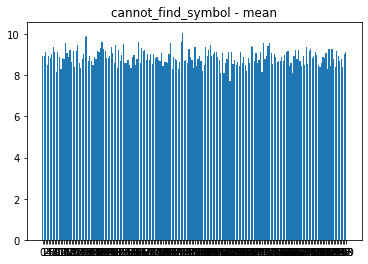

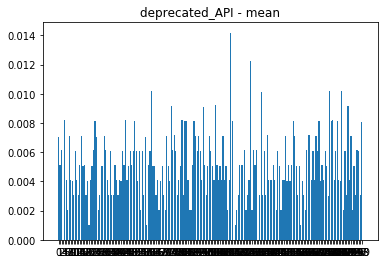

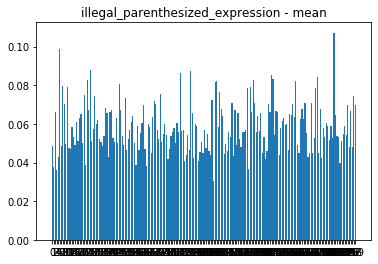

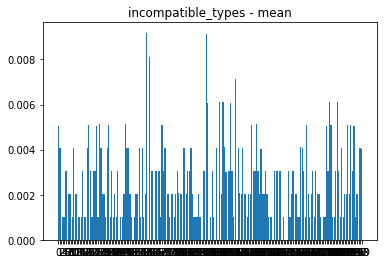

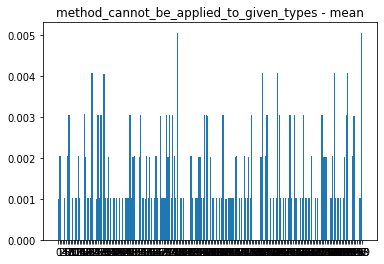

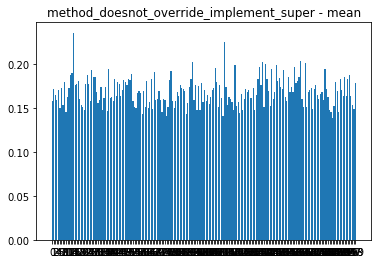

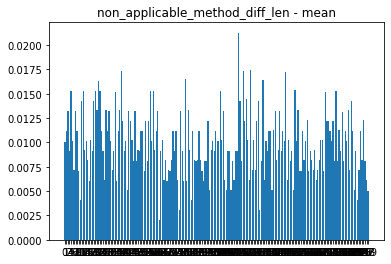

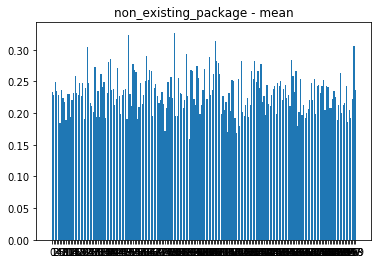

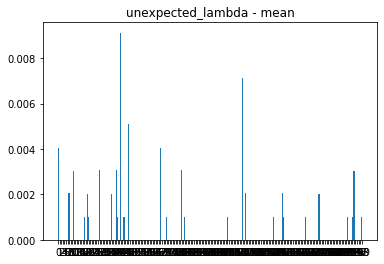

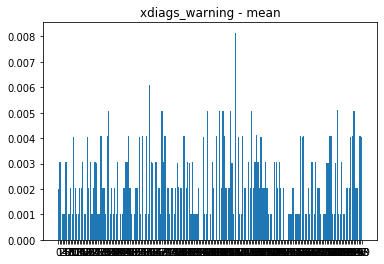

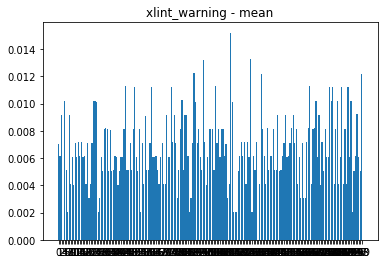

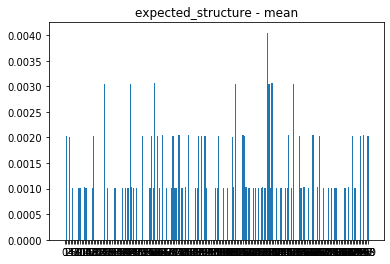

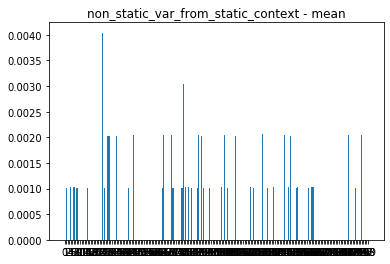

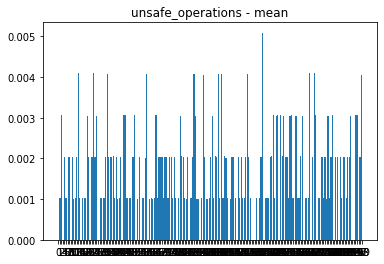

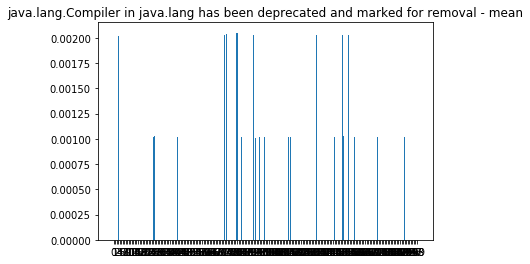

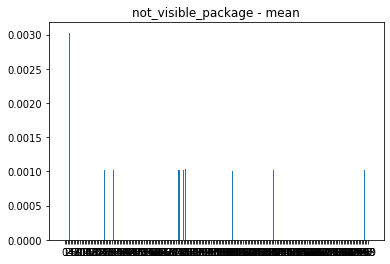

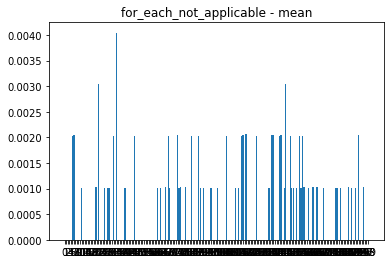

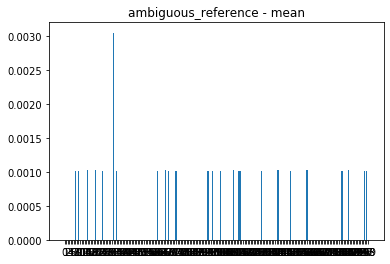

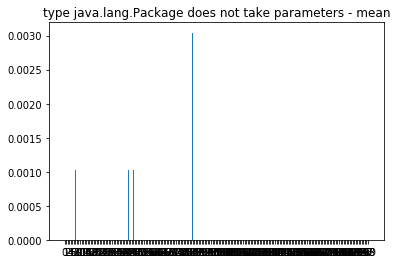

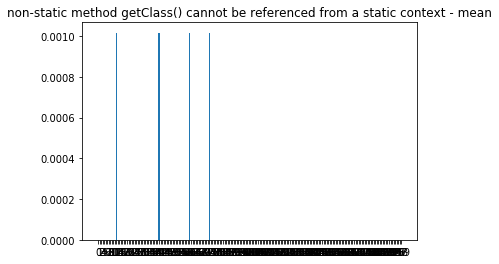

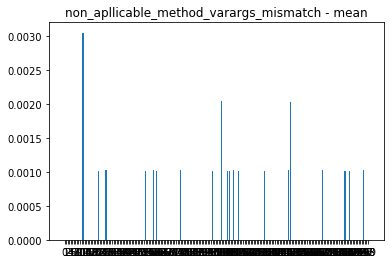

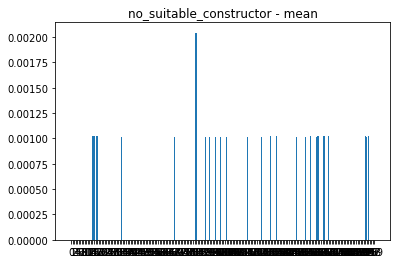

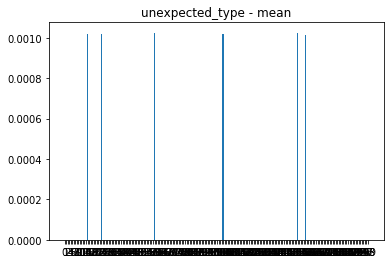

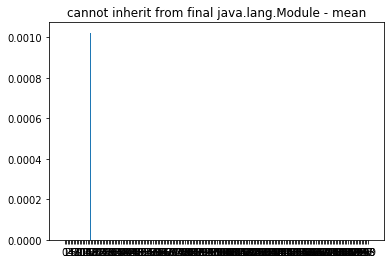

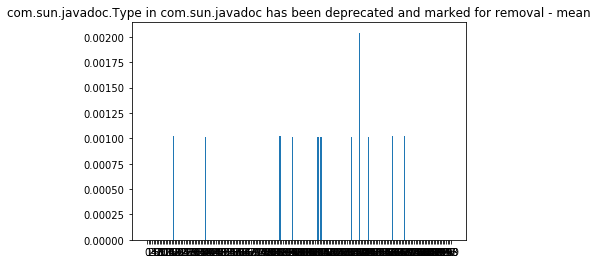

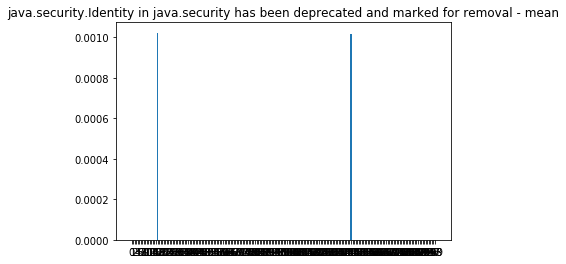

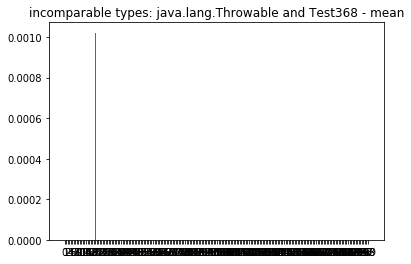

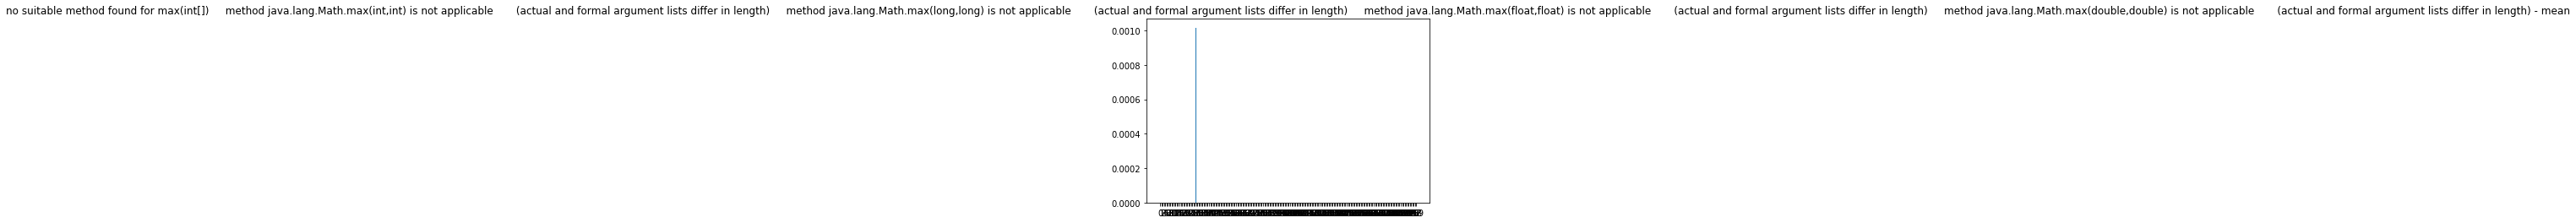

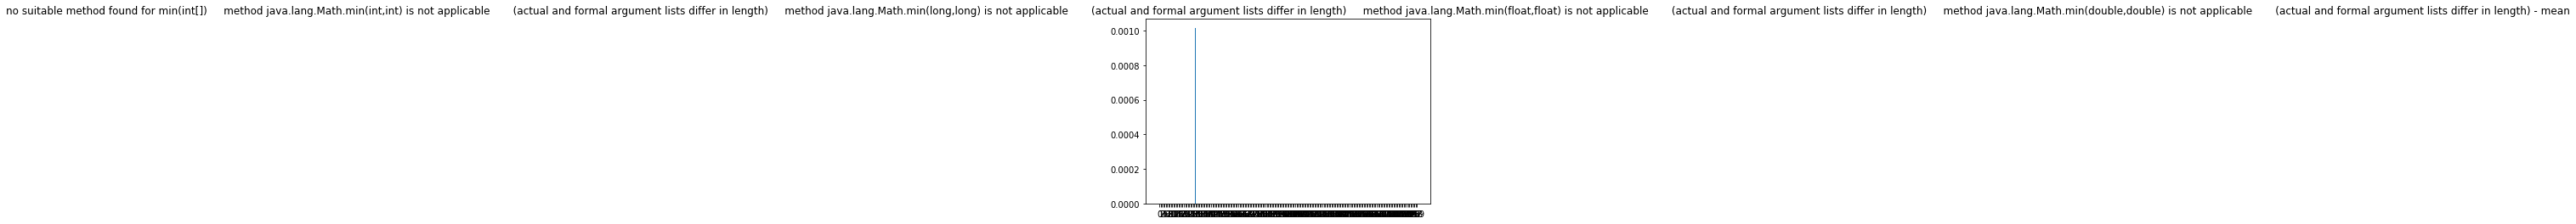

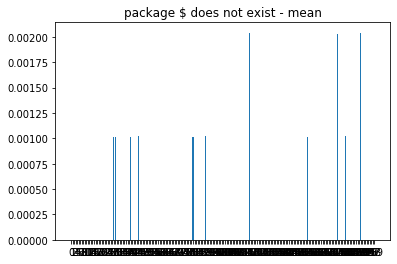

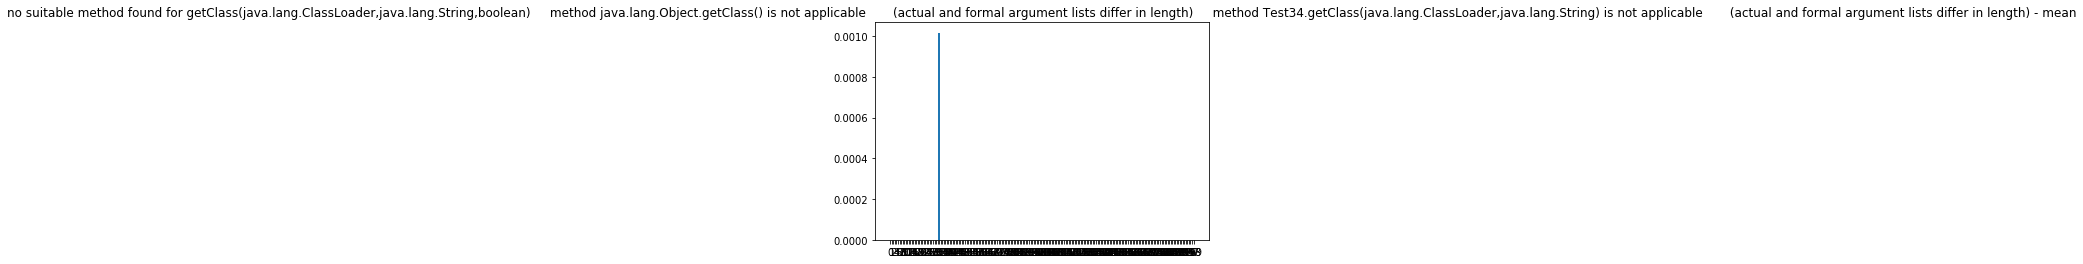

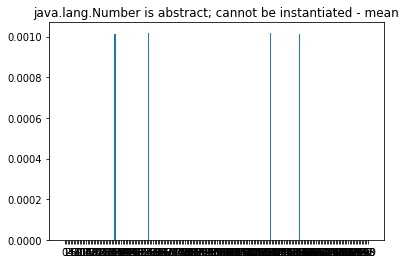

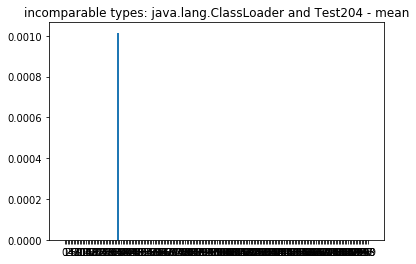

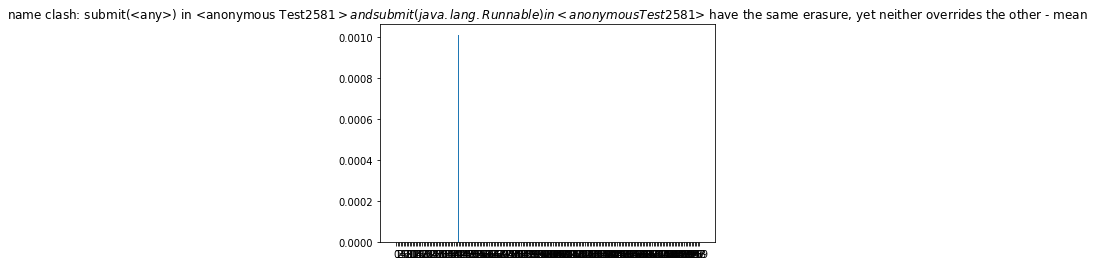

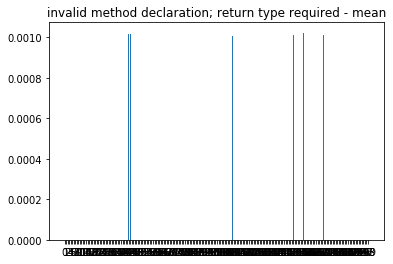

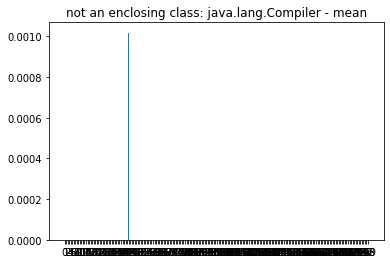

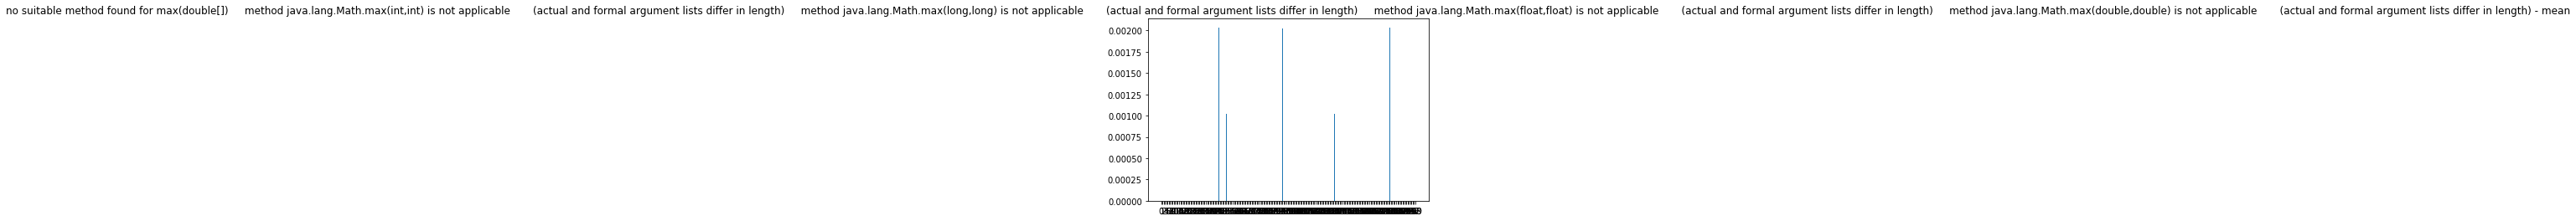

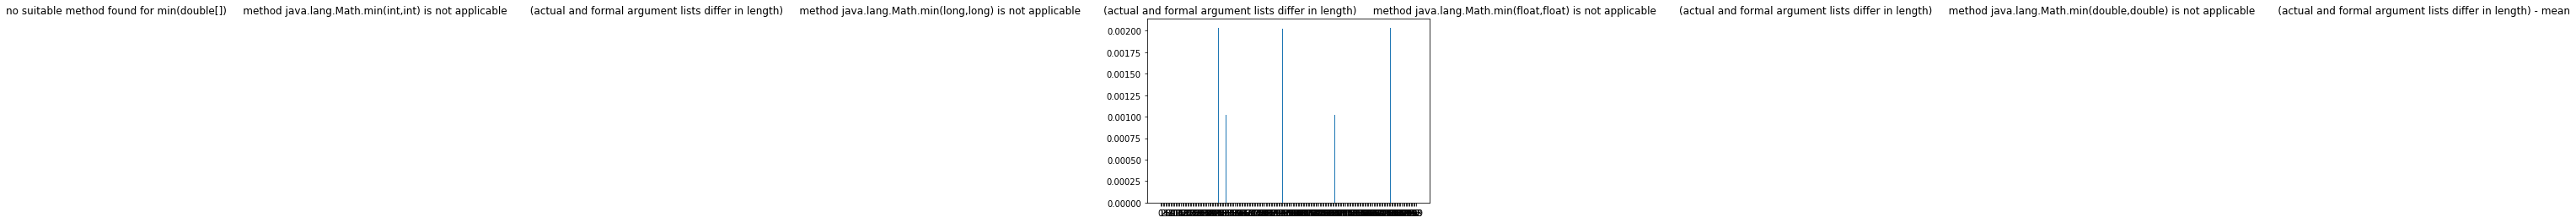

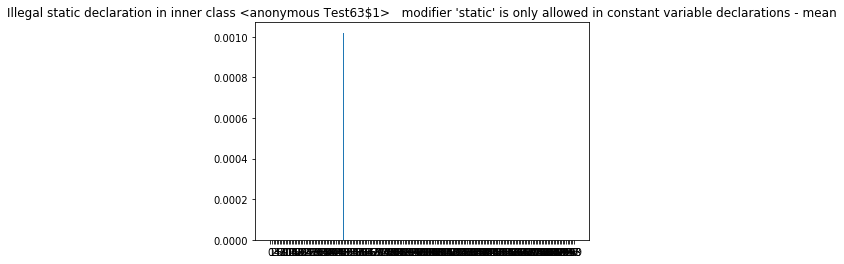

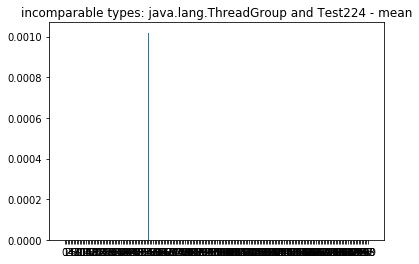

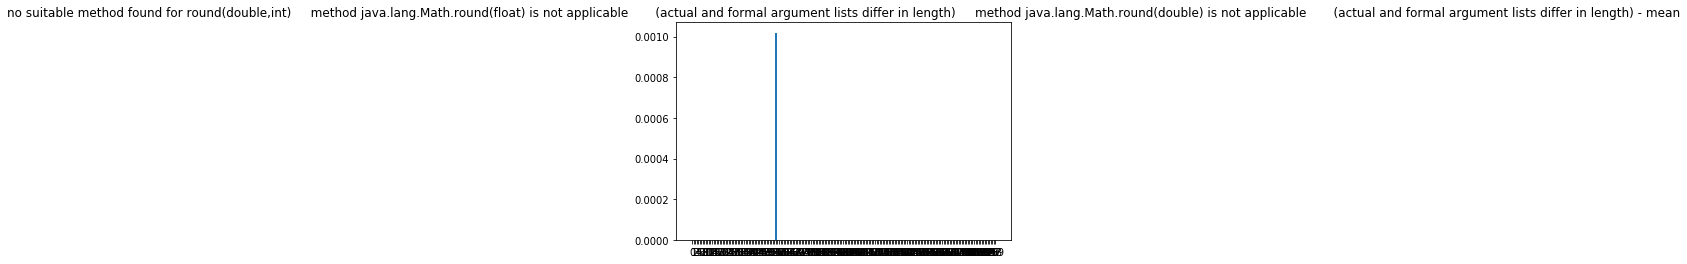

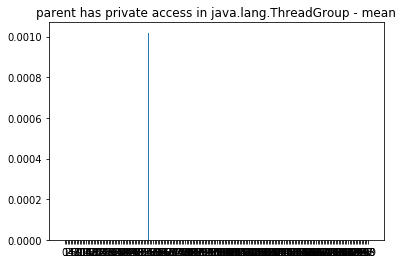

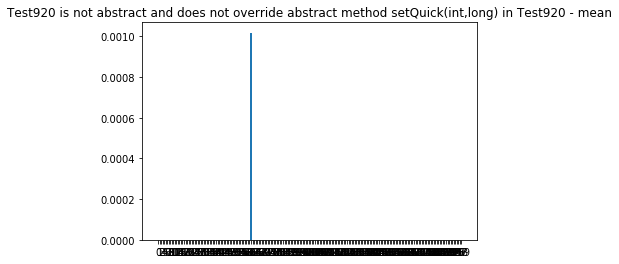

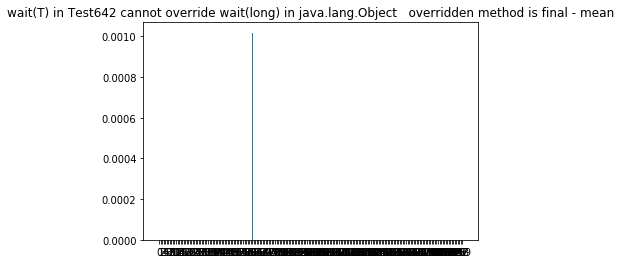

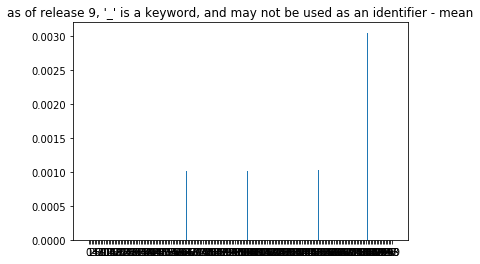

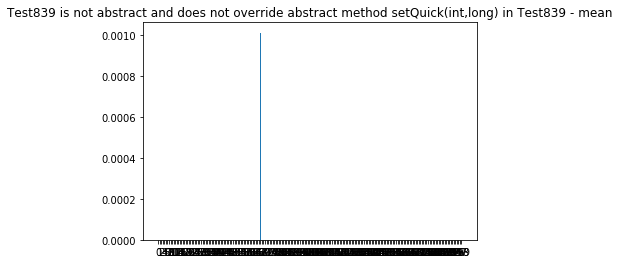

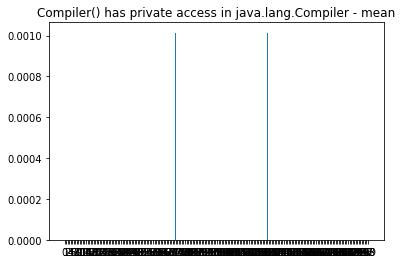

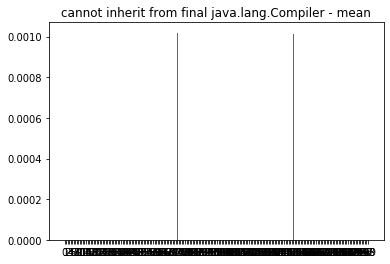

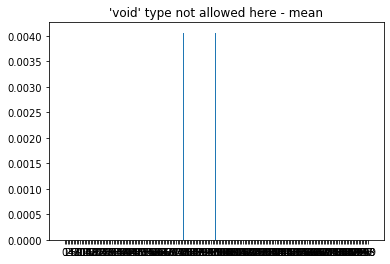

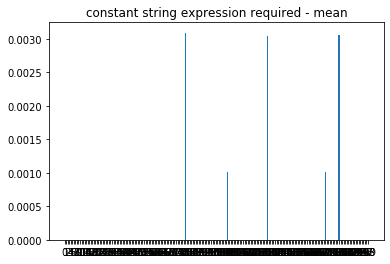

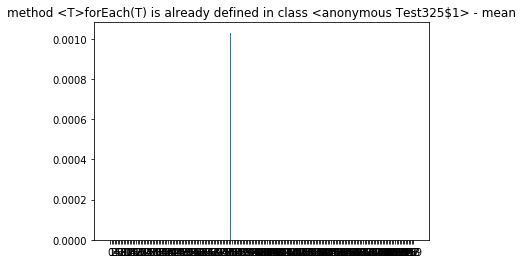

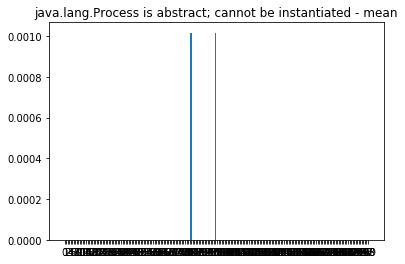

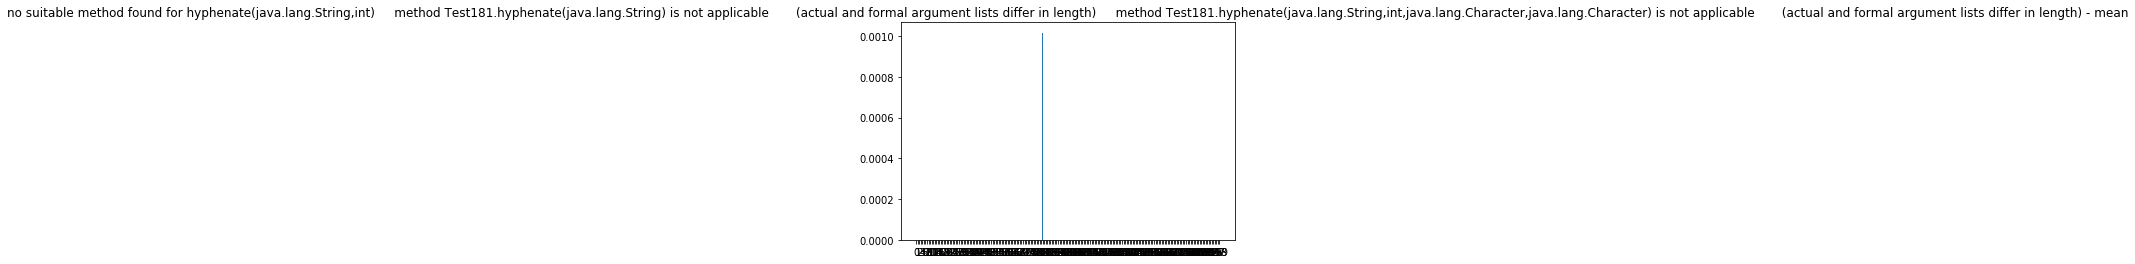

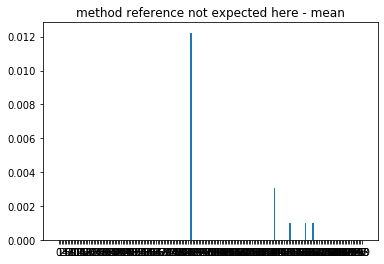

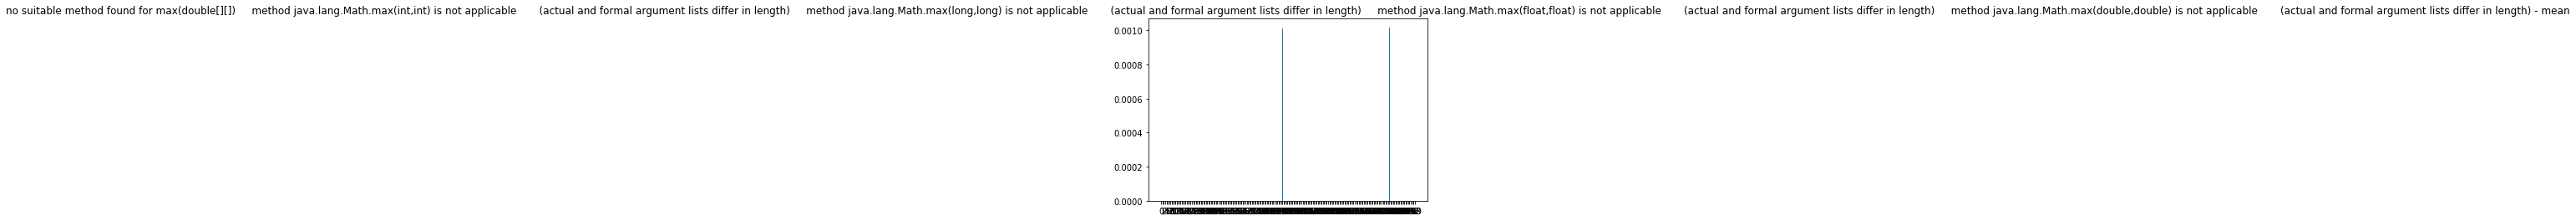

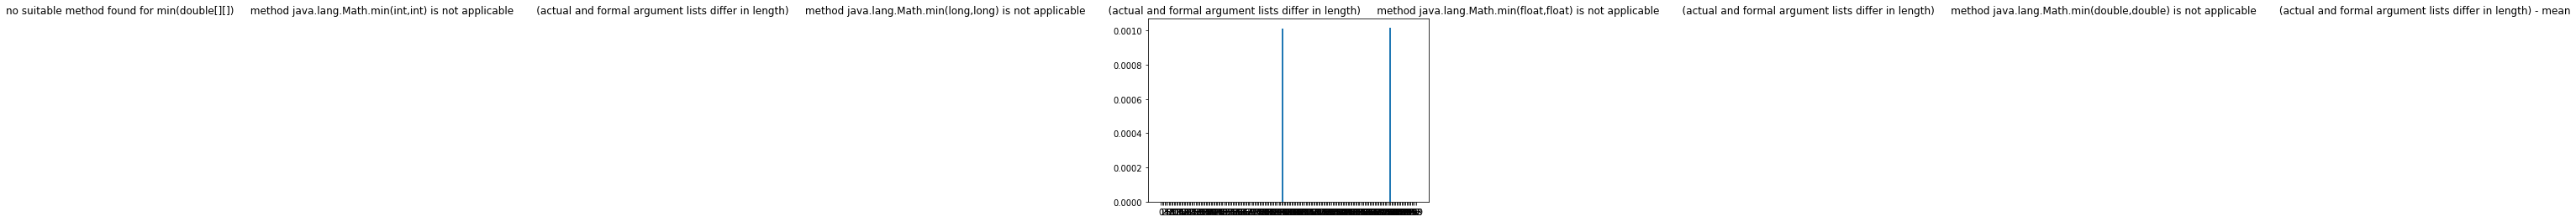

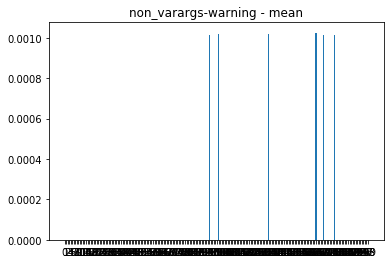

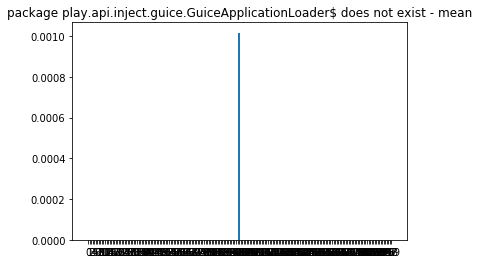

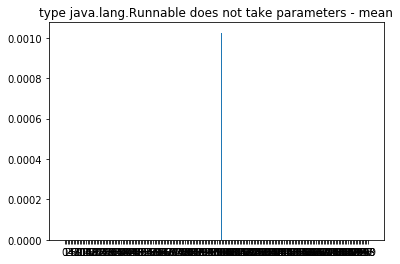

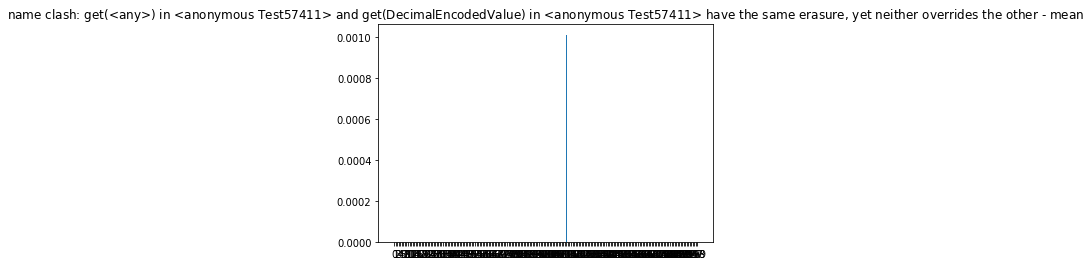

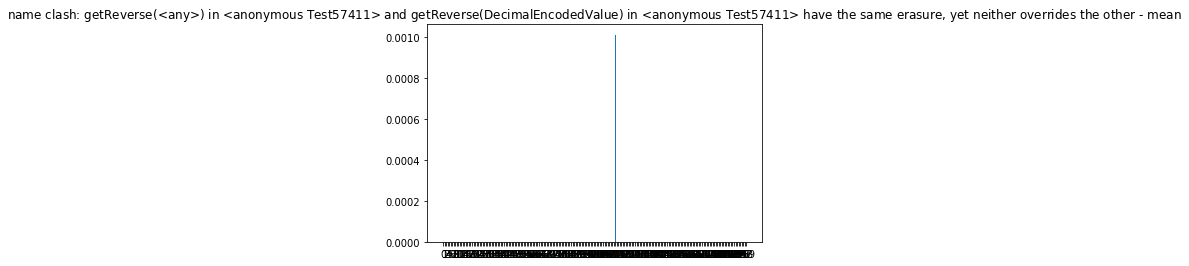

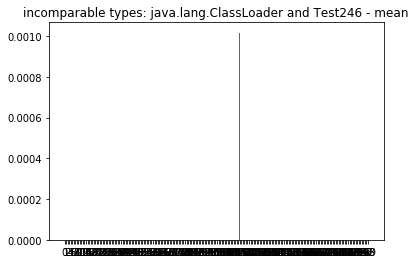

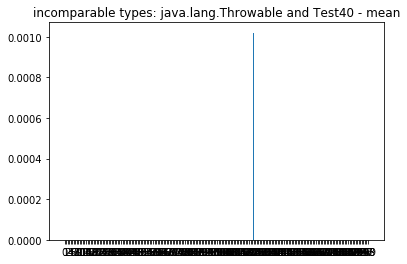

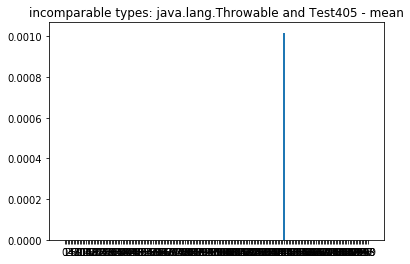

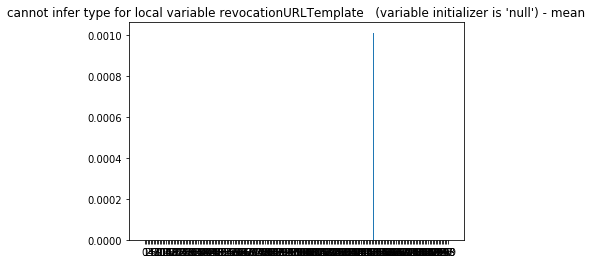

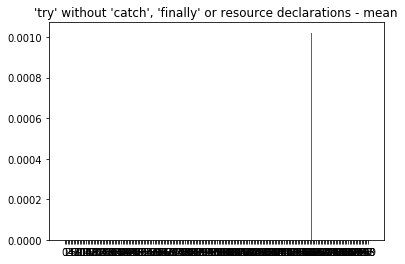

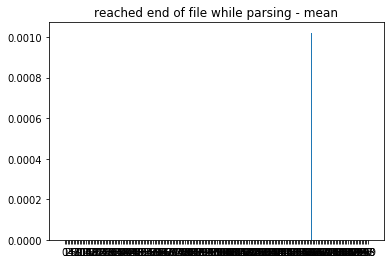

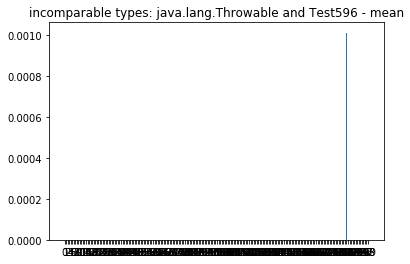

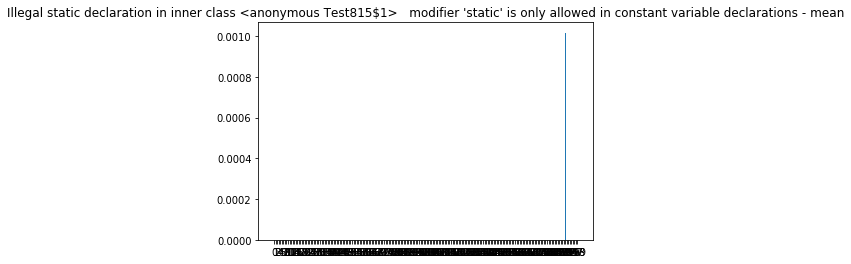

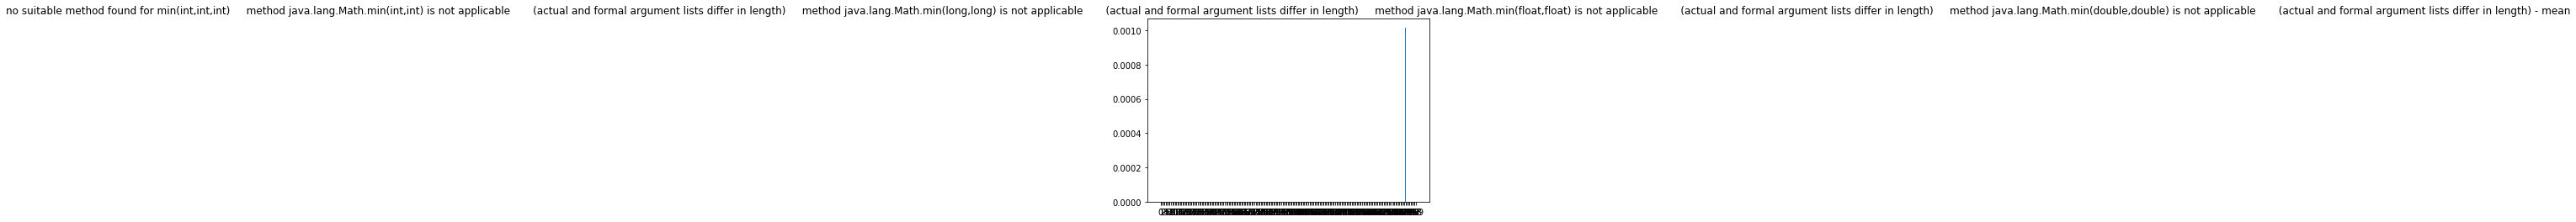

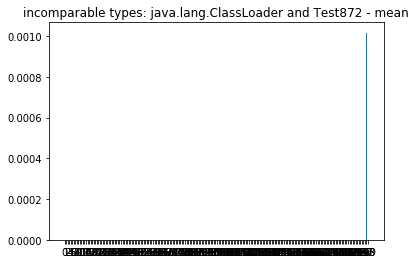

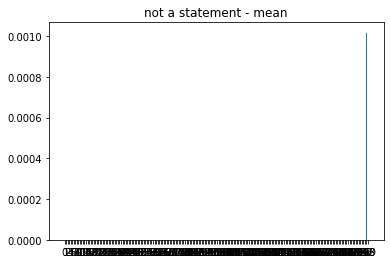

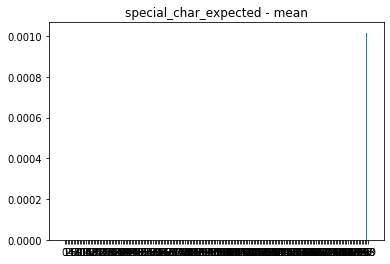

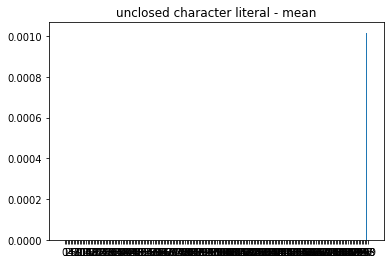

In [449]:
# Evolution of stats over runs

for err in found_errors:
    mean_vals = errors_count[err]['mean']
    std_vals = errors_count[err]['std']
    plt.figure()
    plt.title(f'{err} - mean')
    # Plot the evolution of mean over all the runs
    plt.bar(range(len(mean_vals)), mean_vals)
    plt.xticks(np.arange(0, len(mean_vals), 1))
    
plt.show()